## **Cost Prediction for logistic company with Regression**

The main aim is to predict the cost of a trip for a logistic company based on various features

# Main steps
1.   Data exploration
2.   Feature engineering
3.   Handling missing values
5.   Handling outliers
6.   Data normalization
7.   ML model building
8.   Model deployment






















In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn import linear_model, preprocessing, feature_selection
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train = pd.read_csv("https://raw.githubusercontent.com/priyankaa-k/Databases1/main/Regression_train.csv")
train.head()

,trip,date,dayPart,exWeatherTag,originLocation,destinationLocation,distance,type,weight,packageType,carrier,cost
0,t52712528,2017-09-06,night,NaN,S4,D7,2200,expedited,50,NaN,D,68.413152
1,t29859381,2017-10-21,night,NaN,S8,D1,1800,NaN,12,NaN,B,36.450649
2,t25702332,2017-07-15,night,NaN,S9,D5,2800,NaN,1,NaN,B,9.057939
3,t27713405,2017-10-22,day,NaN,S9,D7,3200,NaN,50,NaN,C,57.320087
4,t49439220,2019-12-11,day,snow,S9,D1,2000,NaN,43,NaN,B,77.263777


In [3]:
#Data exploration
print("shape of the Original data",train.shape)

shape of the Original data (38999, 12)


In [4]:
#description of the train data
train.describe()

,distance,weight,cost
count,38999.000000,38999.000000,38999.000000
mean,2004.061643,42.293033,80.972210
std,728.996843,75.473752,180.715055
min,400.000000,1.000000,5.000000
25%,1400.000000,13.000000,38.768742
50%,2000.000000,25.000000,46.468476
75%,2600.000000,39.000000,70.239797
max,3600.000000,500.000000,2019.734797


In [5]:
#checking the Dtype of the features
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38999 entries, 0 to 38998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   trip                 38999 non-null  object 
 1   date                 38999 non-null  object 
 2   dayPart              38999 non-null  object 
 3   exWeatherTag         4882 non-null   object 
 4   originLocation       38999 non-null  object 
 5   destinationLocation  38999 non-null  object 
 6   distance             38999 non-null  int64  
 7   type                 3748 non-null   object 
 8   weight               38999 non-null  int64  
 9   packageType          2500 non-null   object 
 10  carrier              38999 non-null  object 
 11  cost                 38999 non-null  float64
dtypes: float64(1), int64(2), object(9)
memory usage: 3.6+ MB


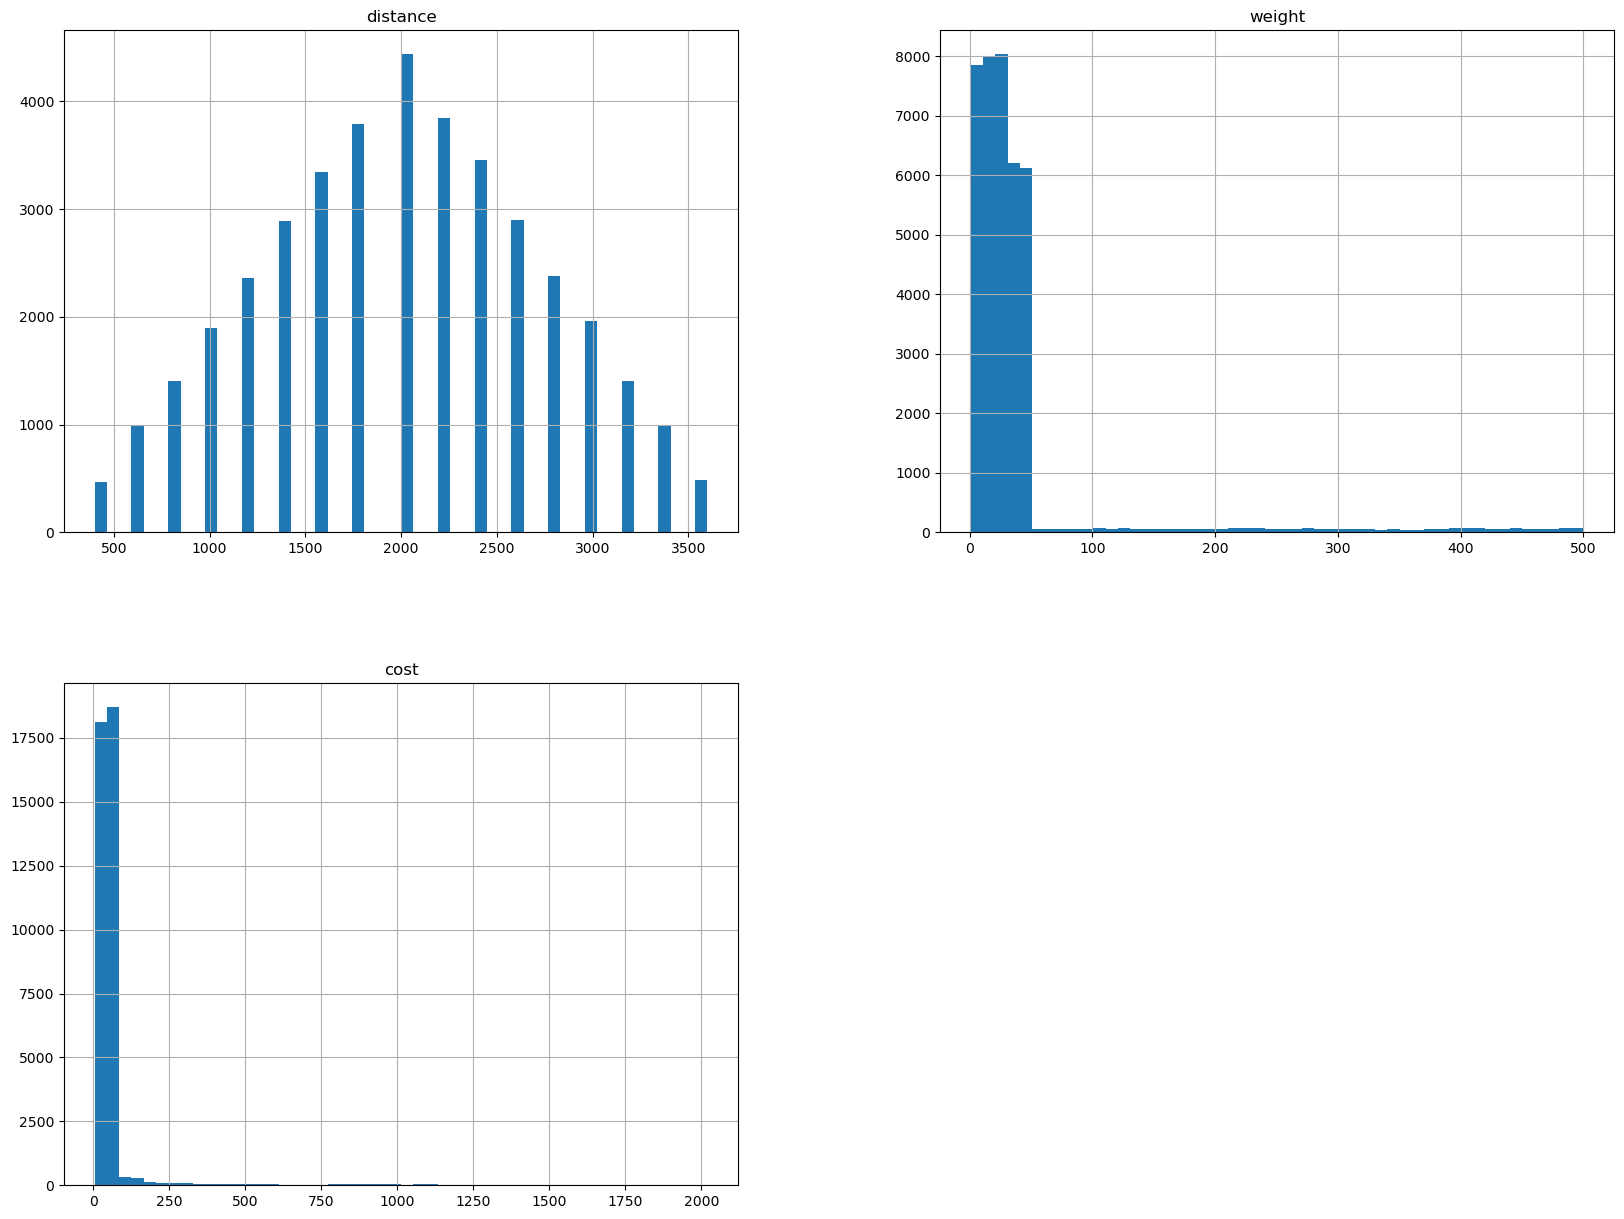

In [6]:
## Analyse the continuous values by creating histograms to understand the distribution
train.hist(bins=50, figsize=(20,15))
plt.show()

The above plots shows that cost, weight and distance has continuous values and the remaining features are categorical which has to be encoded

# Data preprocessing

Feature engineering

In [4]:
#Function to feature engineer the date attribute by separting the date value into data,month and year
def feature_engg(df):
  #As date is object type first changing its datatype to datetime
  df['date']=pd.to_datetime(df['date'])
  #creating new feature Trip_date which will have all the dates
  df['Trip_date'] = df['date'].dt.day
   #creating new feature Trip_year which will have all the years
  df['Trip_year'] = pd.DatetimeIndex(df.date).year
  #creating new feature Trip_month which will have all the months
  df['Trip_month'] = pd.DatetimeIndex(df.date).month
  #creating new feature Trip_day which will have all the days
  df['Trip_day'] =  df['date'].dt.day_name()
  return df

In [5]:
#Applying feature_engg function to train DF
feature_engg(train)
train.head()

,trip,date,dayPart,exWeatherTag,originLocation,destinationLocation,distance,type,weight,packageType,carrier,cost,Trip_date,Trip_year,Trip_month,Trip_day
0,t52712528,2017-09-06,night,NaN,S4,D7,2200,expedited,50,NaN,D,68.413152,6,2017,9,Wednesday
1,t29859381,2017-10-21,night,NaN,S8,D1,1800,NaN,12,NaN,B,36.450649,21,2017,10,Saturday
2,t25702332,2017-07-15,night,NaN,S9,D5,2800,NaN,1,NaN,B,9.057939,15,2017,7,Saturday
3,t27713405,2017-10-22,day,NaN,S9,D7,3200,NaN,50,NaN,C,57.320087,22,2017,10,Sunday
4,t49439220,2019-12-11,day,snow,S9,D1,2000,NaN,43,NaN,B,77.263777,11,2019,12,Wednesday


## Missing values

Visualizing missing values

In [10]:
#checking the count of Nan values
train.isnull().sum()

trip                       0
date                       0
dayPart                    0
exWeatherTag           34117
originLocation             0
destinationLocation        0
distance                   0
type                   35251
weight                     0
packageType            36499
carrier                    0
cost                       0
Trip_date                  0
Trip_year                  0
Trip_month                 0
Trip_day                   0
dtype: int64

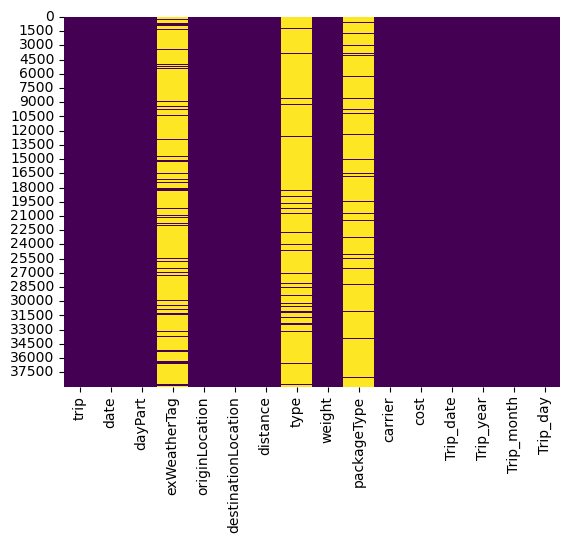

In [11]:
#Heat map which highlights missing values with yellow color in train df.
sns.heatmap(train.isnull(),  cmap='viridis', cbar=False)

# Show the plot
plt.show()

 The above heat map shows the features exWheatherTag, type, package_type has a lot of missing values.

Let's plot these features with Cost to visualize the realation

In [12]:
## make the list of features which has missing values
features_with_na= [features for features in train.columns if train[features].isnull().sum()>1]


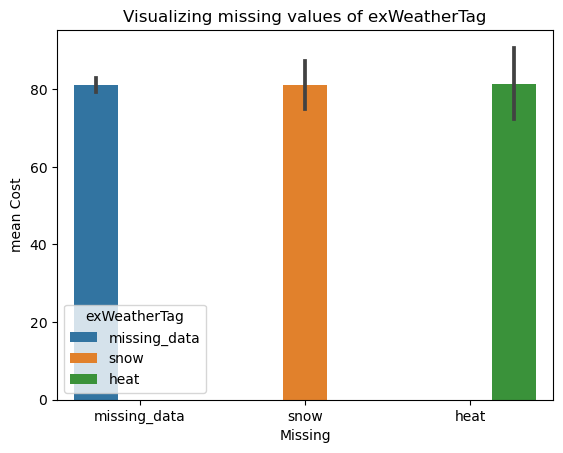

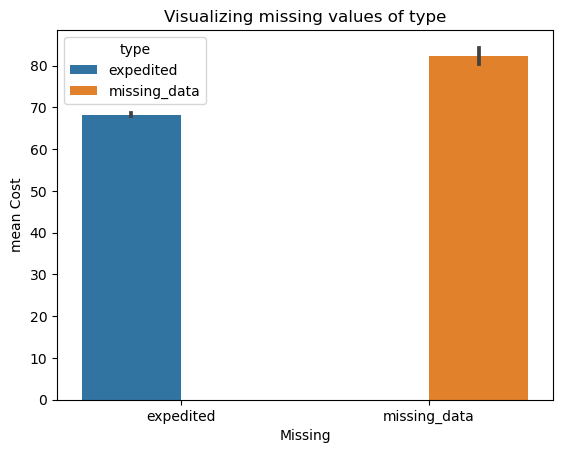

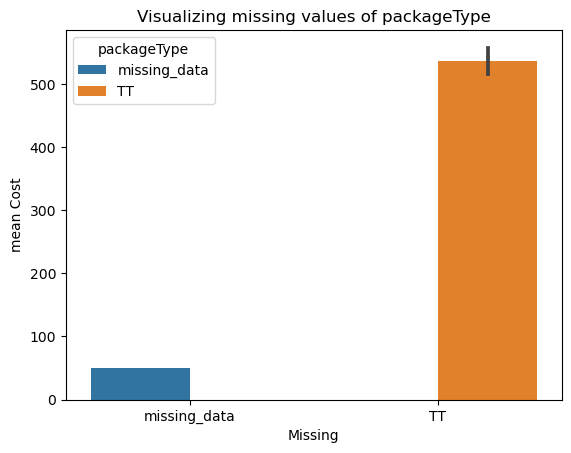

In [13]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["TF_CPP_MIN_LOG_LEVEL"]="5"
for feature in features_with_na:
    train_copy = train.copy()

    # let's make a variable that indicates 1 if the observation was missing or zero otherwise
    train_copy[feature] = np.where(train_copy[feature].isnull(), 'missing_data',train_copy[feature] )

    # let's calculate the mean cost where the information is missing or present
    ax = sns.barplot(x=feature, y='cost', data=train_copy, estimator=np.mean, hue=feature)

    ax.set_title('Visualizing missing values of '+feature)
    ax.set_xlabel('Missing')
    ax.set_ylabel('mean Cost')

    plt.show()

Here With  the relation between the missing values and the dependent variable is clearly visible.So We need to replace these nan values with something meaningful which we will do in the further section. However we can observe that feature pacakageType has less relation with cost. So we can drop the feature

Handling missing values

In [6]:
def handling_missing_values(df):
  #Three feature values have null values

  def replace_weather(row):
      #Handling Null values of exWeatherTag using Trip_month feature according to canadian whether
      #assigning whether values to the months
      month_to_weather = {
          1: 'snow',      # January (winter)
          2: 'snow',      # February (winter)
          3: 'spring',    # March (spring)
          4: 'spring',    # April (spring)
          5: 'spring',    # May (spring)
          6: 'hot',       # June (summer)
          7: 'hot',       # July (summer)
          8: 'hot',       # August (summer)
          9: 'hot',       # September (summer)
          10: 'snow',     # October (winter)
          11: 'snow',     # November (winter)
          12: 'snow'      # December (winter)
      }

      # Replace the weather values based on the month_to_weather mapping
      df['exWeatherTag'] = df['Trip_month'].map(month_to_weather)
      return df

  # Apply the function to fill NaN values in exWeatherTag
  df = replace_weather(df)


  #creating dummies for type feature
  df['type'] = pd.get_dummies(df['type'], prefix='type')



Before handling nan values for exWeatherTag


[Text(0, 0.0, '0'),
 Text(0, 500.0, '500'),
 Text(0, 1000.0, '1000'),
 Text(0, 1500.0, '1500'),
 Text(0, 2000.0, '2000'),
 Text(0, 2500.0, '2500'),
 Text(0, 3000.0, '3000'),
 Text(0, 3500.0, '3500')]

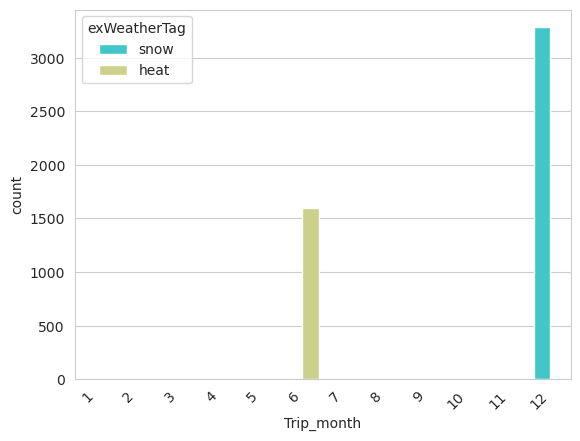

In [16]:
#Visualizing "exWeatherTag" feature missing values using "Trip_month" feature
print("Before handling nan values for exWeatherTag")
sns.set_style('whitegrid')
ax = sns.countplot(x='Trip_month',hue='exWeatherTag',data=train,palette='rainbow')
# Set labels on the right side
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right")

In [7]:
handling_missing_values(train)

In [18]:
train.head()

,trip,date,dayPart,exWeatherTag,originLocation,destinationLocation,distance,type,weight,packageType,carrier,cost,Trip_date,Trip_year,Trip_month,Trip_day
0,t52712528,2017-09-06,night,hot,S4,D7,2200,1,50,NaN,D,68.413152,6,2017,9,Wednesday
1,t29859381,2017-10-21,night,snow,S8,D1,1800,0,12,NaN,B,36.450649,21,2017,10,Saturday
2,t25702332,2017-07-15,night,hot,S9,D5,2800,0,1,NaN,B,9.057939,15,2017,7,Saturday
3,t27713405,2017-10-22,day,snow,S9,D7,3200,0,50,NaN,C,57.320087,22,2017,10,Sunday
4,t49439220,2019-12-11,day,snow,S9,D1,2000,0,43,NaN,B,77.263777,11,2019,12,Wednesday


After handling nan values for exWeatherTag


[Text(0, 0.0, '0'),
 Text(0, 500.0, '500'),
 Text(0, 1000.0, '1000'),
 Text(0, 1500.0, '1500'),
 Text(0, 2000.0, '2000'),
 Text(0, 2500.0, '2500'),
 Text(0, 3000.0, '3000'),
 Text(0, 3500.0, '3500'),
 Text(0, 4000.0, '4000')]

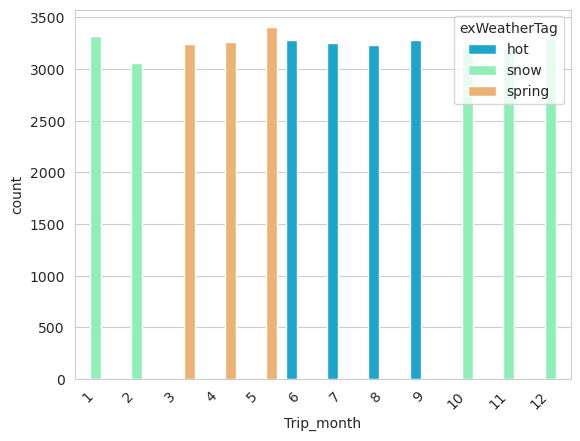

In [19]:
#Visualizing "exWeatherTag" feature missing values using "Trip_month" feature
print("After handling nan values for exWeatherTag")
sns.set_style('whitegrid')
ax = sns.countplot(x='Trip_month',hue='exWeatherTag',data=train,palette='rainbow')
# Set labels on the right side
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right")

Handling Outliers

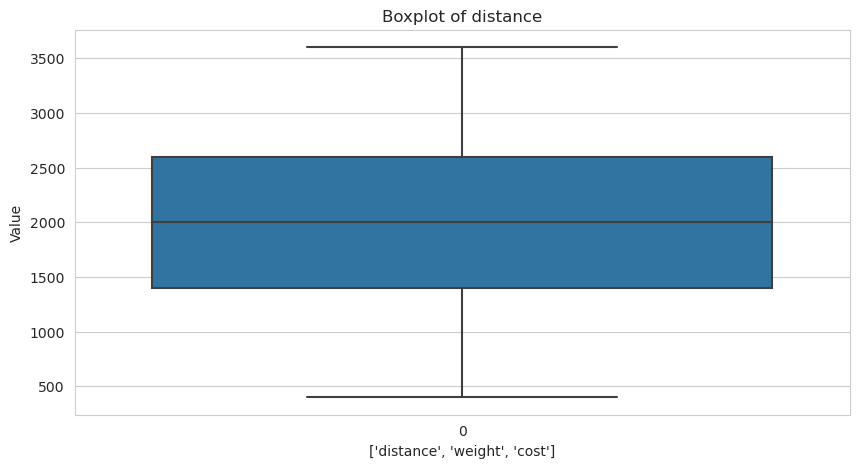

None


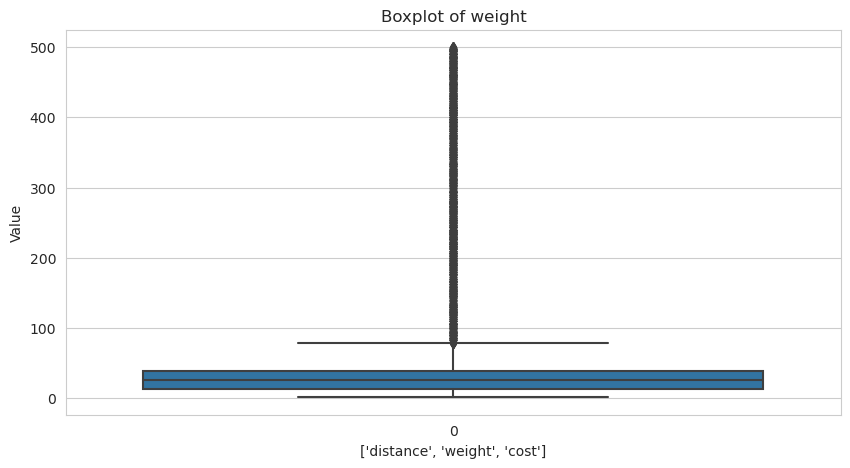

None


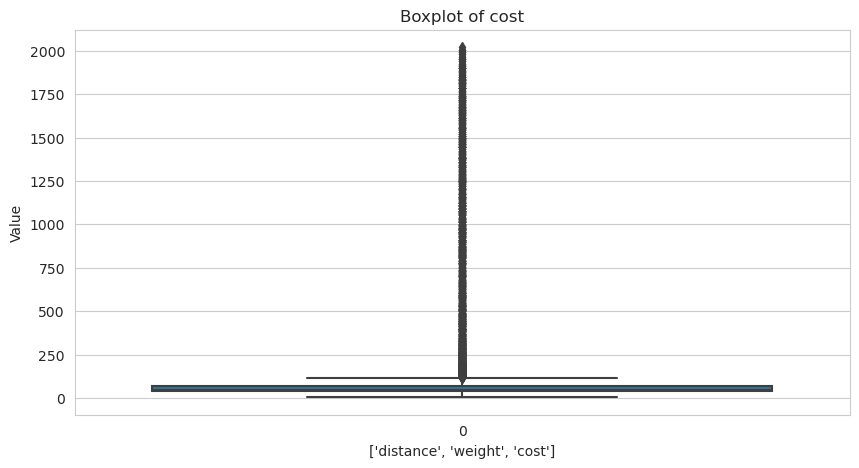

None
visualizing outliers before handling them None


In [20]:
#numerical columns
col_numerical = ['distance','weight','cost']
def visualize_outliers(df):
    #visualizing the outliers using bocx ploat
    columns_to_plot = col_numerical
    # Loop through each column and plot the box plot
    for i, col in enumerate(columns_to_plot):
      plt.figure(figsize=(10,5))
      plt.subplots_adjust(wspace=0.5, hspace=0.5)
      sns.boxplot(data=df[col])
      plt.title(f'Boxplot of {col}')
      plt.xlabel(col_numerical)
      plt.ylabel('Value')
      print(plt.show())

#Applying function to train df
print("visualizing outliers before handling them", visualize_outliers(train))

In [21]:
#numerical columns
col_numerical = ['distance','weight']
def outliers(df):
  #visualizing and handling outliers for numerical features

  def visualize_outliers(df):
    #visualizing the outliers using bocx ploat
    columns_to_plot = col_numerical
    # Loop through each column and plot the box plot
    for i, col in enumerate(columns_to_plot):
      plt.figure(figsize=(10,5))
      plt.subplots_adjust(wspace=0.5, hspace=0.5)
      sns.boxplot(data=df[col])
      plt.title(f'Boxplot of {col}')
      plt.xlabel(col_numerical)
      plt.ylabel('Value')
      print(plt.show())

  print("visualizing outliers before handling them", visualize_outliers(df))

  def handle_outliers_in_dataframe(df):
    #handling outliers using imputation of mean values

    mean_value = df.mean()
    # Replace outliers with the mean value for each column
    df_handled = df.apply(lambda col: np.where(
        np.abs(col - col.mean()) > 1.5 * (col.quantile(0.75) - col.quantile(0.25)),
        mean_value[col.name], col)
    )
    return df_handled

  df[col_numerical] = handle_outliers_in_dataframe(df[col_numerical])

  print("visualizing outliers after handling them", visualize_outliers(df))



In [22]:
# outliers(train)

Reason for not handling the above code which apply handling outliers function to train is cost and weight has hight corelation and they are skewed in same manner so outliers for weight is also contributing to predict cost

Dropping the unwanted columns

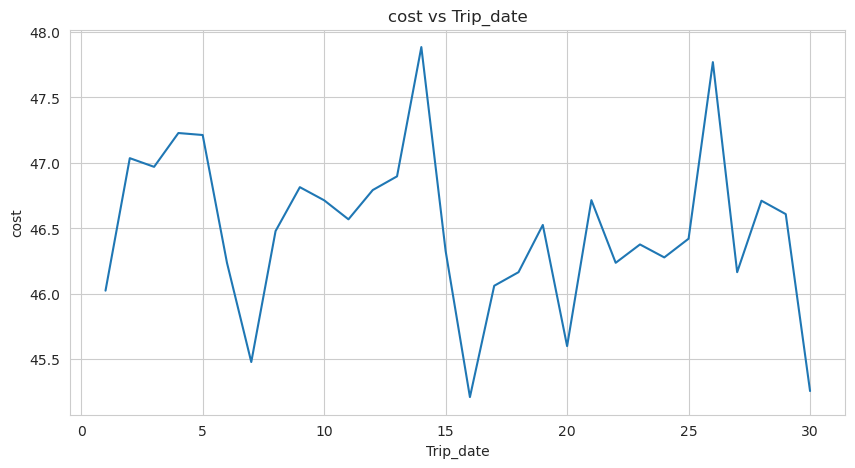

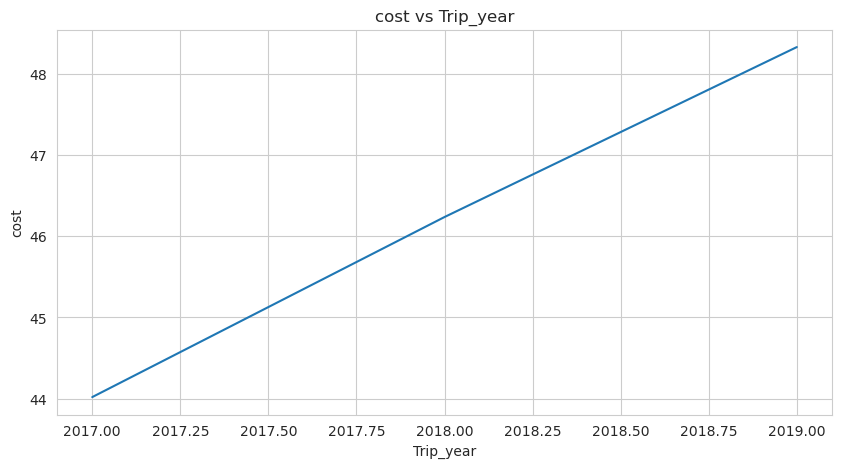

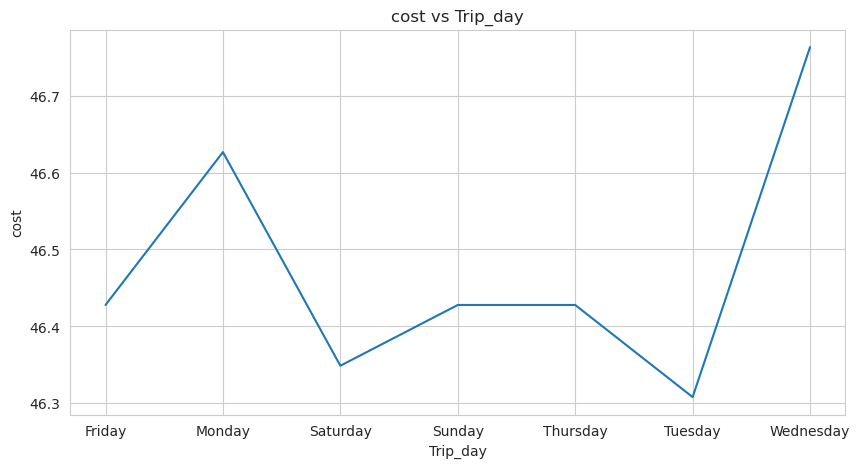

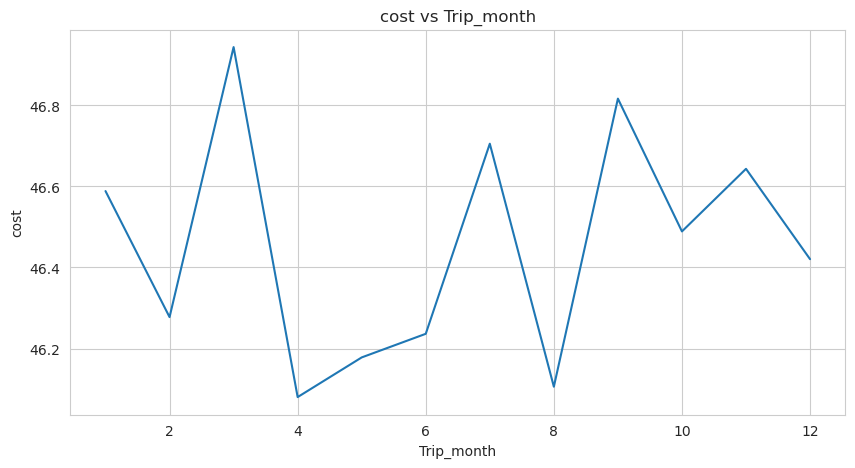

In [23]:
## Lets analyze the Temporal Datetime Variables
## We will check whether there is a relation between year the cost
date_cols = ['Trip_date','Trip_year','Trip_day','Trip_month']
for col in date_cols:
  plt.figure(figsize=(10,5))
  train_copy.groupby(col)['cost'].median().plot()
  plt.xlabel(col)
  plt.ylabel('cost')
  plt.title("cost vs "+col)
  plt.show()

The above plots shows the relation between Traget feature cost and data feartures.


*   Trip_date and cost has various relation, during the date 5,15,30 the cost value is decreased while on other dates it got flactuations but mostly the cost value is high.
*   Trip_year and cost has linear relation, Cost value increased consistently through the years.

*   During the weekends in Trip_day feature cost value is low while on weekdays like wednesday cost value is very high
*   Trip_month has flactuating rate of cost value, between the months sepetember to march mostly the cost value is high which has snow whether. During Hot whether months like April cost value is very low. So the feature exWhetheTag and Trip_month basically gives same insights. So we can drop this column.






In [8]:
# function to drop column from given dataset
def dropSelectedColumns(df, columns):
    for column in columns:
        df = df.drop(column, axis = 1)
    return df

In [9]:
#listing the selected features to drop
drop_columns = ['trip','date','packageType','Trip_date']
#Applying dropSelectedColumns to train df
train = dropSelectedColumns(train, drop_columns)
train.head()

,dayPart,exWeatherTag,originLocation,destinationLocation,distance,type,weight,carrier,cost,Trip_year,Trip_month,Trip_day
0,night,hot,S4,D7,2200,1,50,D,68.413152,2017,9,Wednesday
1,night,snow,S8,D1,1800,0,12,B,36.450649,2017,10,Saturday
2,night,hot,S9,D5,2800,0,1,B,9.057939,2017,7,Saturday
3,day,snow,S9,D7,3200,0,50,C,57.320087,2017,10,Sunday
4,day,snow,S9,D1,2000,0,43,B,77.263777,2019,12,Wednesday


In [10]:
# Define the target column ,categorical,numerical and predictors columns
TARGET = "cost"
columns_predictors = [col for col in train.columns if col not in [TARGET]]
columns_categorical = ['dayPart',  'destinationLocation', 'originLocation','carrier','exWeatherTag','Trip_year', 'Trip_day','Trip_month','type']
columns_numerical = [col for col in columns_predictors  if col not in columns_categorical]
print(f"TARGET: {TARGET}")
print(f"columns_predictors: {columns_predictors}")
print(f"columns_categorical: {columns_categorical}")
print(f"columns_numerical: {columns_numerical}")

TARGET: cost
columns_predictors: ['dayPart', 'exWeatherTag', 'originLocation', 'destinationLocation', 'distance', 'type', 'weight', 'carrier', 'Trip_year', 'Trip_month', 'Trip_day']
columns_categorical: ['dayPart', 'destinationLocation', 'originLocation', 'carrier', 'exWeatherTag', 'Trip_year', 'Trip_day', 'Trip_month', 'type']
columns_numerical: ['distance', 'weight']


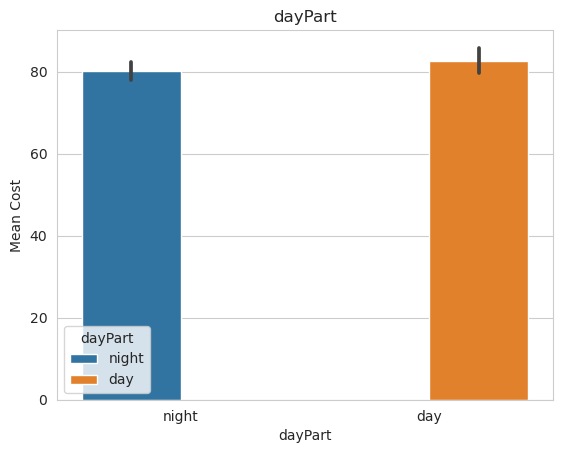

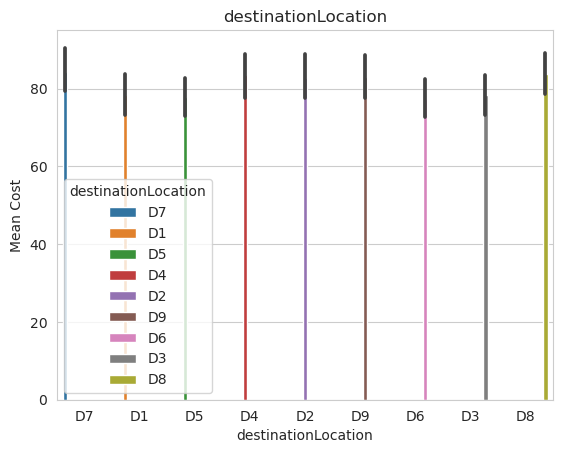

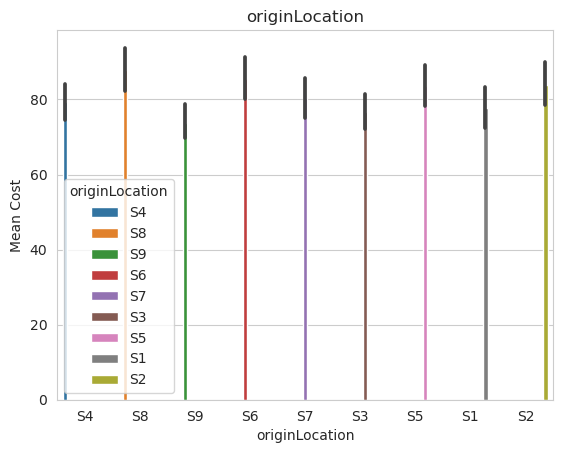

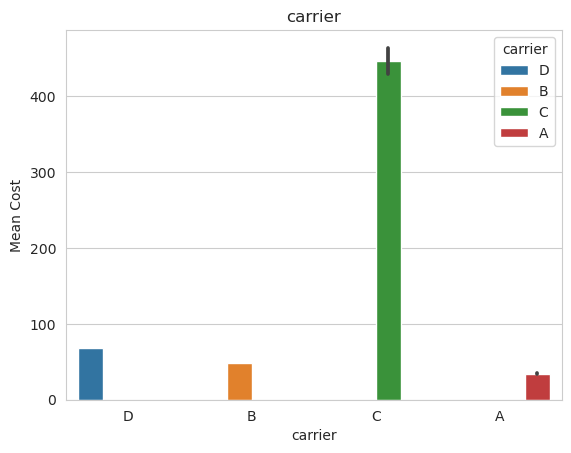

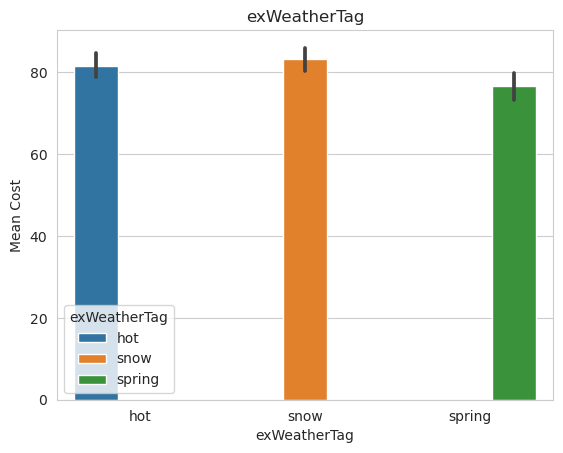

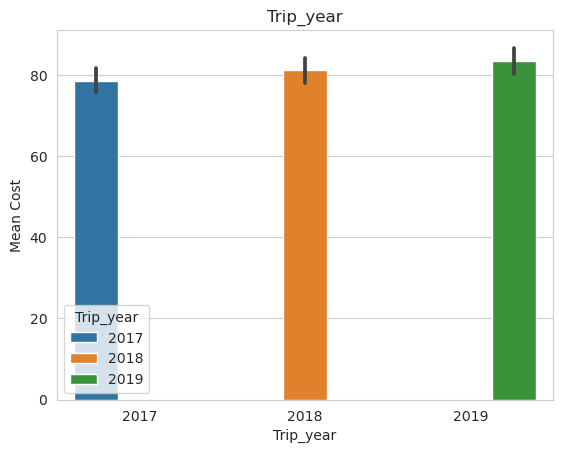

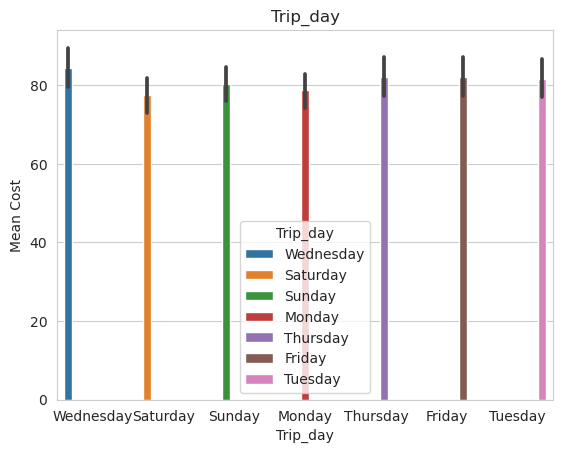

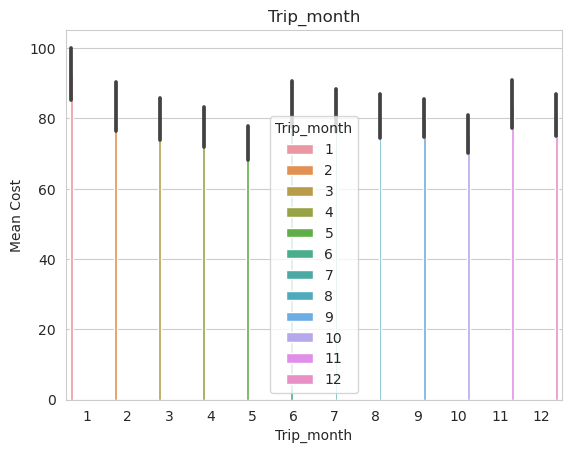

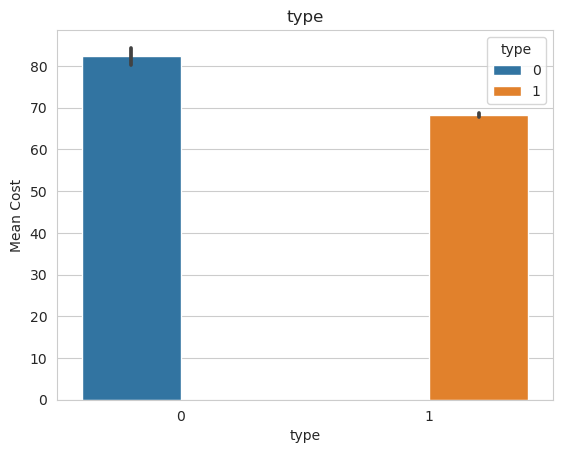

In [27]:
## Lets Find the realtionship between categorical features and cost

for col in columns_categorical:
    train_copy=train.copy()
#     plt.figure(figsize=(15,5))
     # Create a bar plot of the median cost grouped by the categorical column and colored by the column
    ax = sns.barplot(x=col, y='cost', data=train_copy, estimator=np.mean, hue=col)

    # Set the labels and title
    ax.set_xlabel(col)
    ax.set_ylabel('Mean Cost')
    ax.set_title(col)

    # Show the plot
    plt.show()

The  relationship between categorical features  and cost is as follows:


*   All the values in features day_part,Original_location,Destination_location,exWhetherTag, Trip_year, Trip_day, Trip_date are contributing high to the cost
*   Expideted type are more with high cost values while the non-expideted type has fair cost value.
*   The Carrier C has contributing more for cost value while other carriers has cost values between 0-60.



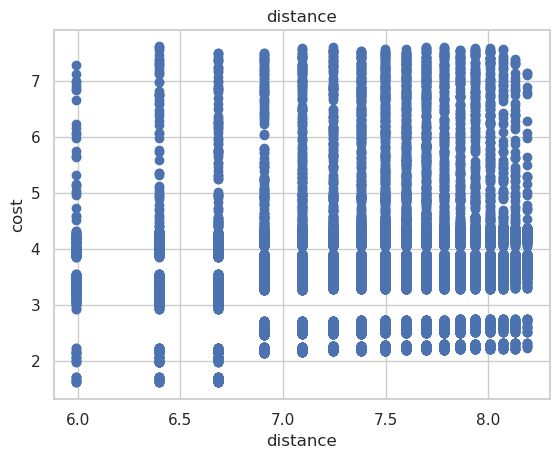

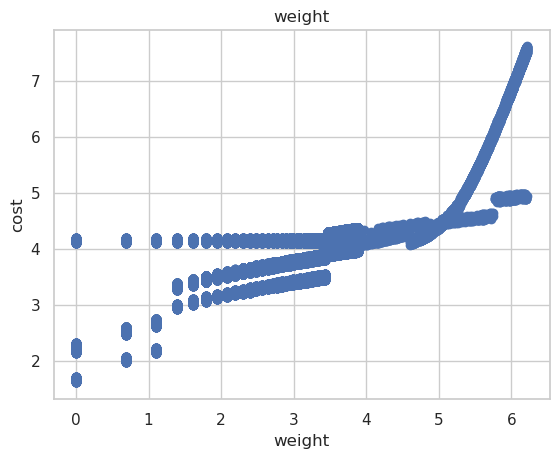

In [34]:
## We will be using logarithmic transformation


for col in columns_numerical:
    train_copy=train.copy()
    if 0 in train_copy[col].unique():
        pass
    else:
        train_copy[col]=np.log(train_copy[col])
        train_copy['cost']=np.log(train_copy['cost'])
        plt.scatter(train_copy[col],train_copy['cost'])
        plt.xlabel(col)
        plt.ylabel('cost')
        plt.title(col)
        plt.show()


1.  The above plot shows that relation between cost and distance is not linear.
2.  The weight and cost are correlated and up to weight value 5 cost value is consistent and above that weight cost value started increasing.



Lets dig depper into the features weight and Carrier Vs cost

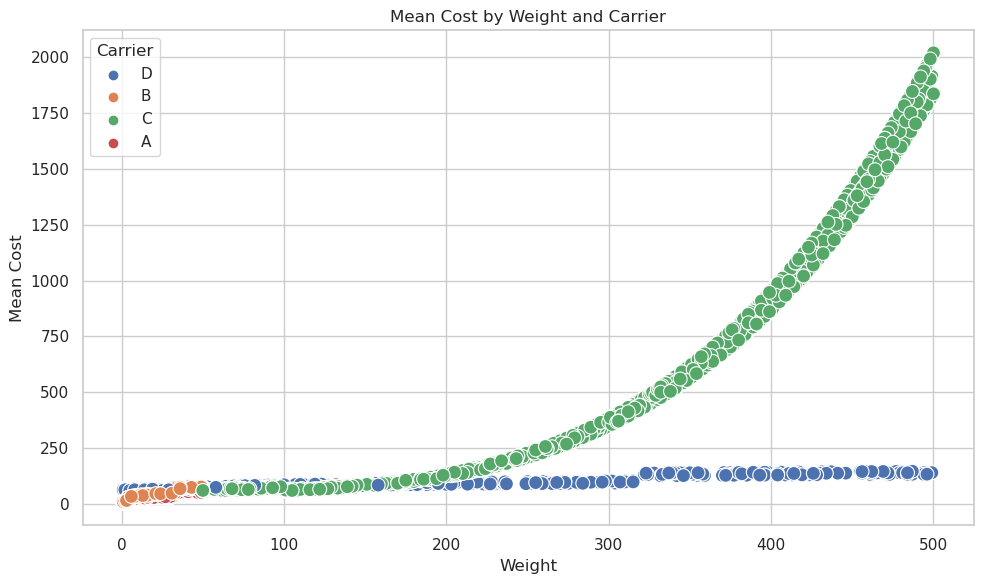

In [32]:
# Create a grouped bar plot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x="weight", y="cost", hue="carrier", data=train, s=100)

# Set plot title and labels
plt.title("Mean Cost by Weight and Carrier")
plt.xlabel("Weight")
plt.ylabel("Mean Cost")
plt.legend(title="Carrier")

plt.tight_layout()
plt.show()

From the above scatter plot, the relationship between "weight," "cost," and the different carriers are as below

Carrier C - Weight and Cost Relationship:
For carrier C, there appears to be a positive correlation between "weight" and "cost." As the weight of the items increases, the associated cost also tends to increase. This trend suggests that carrier C might have a pricing structure that takes into account the weight of the items being transported. Heavier shipments are likely to incur higher costs, potentially due to increased handling or resource requirements.

Other Carriers - Consistent Weight and Cost:
In contrast to carrier C, carriers A,B and D exhibit a relatively consistent pattern of both "weight" and "cost." The points for carriers A and B are more clustered around a certain range of weights and costs. This suggests that the cost calculation for these carriers might be influenced by factors other than weight. Other factors, such as distance, delivery speed, or additional services, might play a more significant role in determining the cost for carriers A and B.

Business Implications:
The observed relationship between weight and cost for carrier C could influence the decisions of customers and businesses. Customers sending heavy shipments might need to budget for higher costs when choosing carrier C, while those with lighter shipments might find carriers A, B and D more cost-effective. Businesses shipping goods of varying weights might benefit from these insights to optimize their carrier selection based on their specific requirements and cost constraints.


In [11]:
#Spliting data into dependent and independent varaiables
X_train = train[columns_predictors]
y_train = train[TARGET]

In [12]:
print('X_train and y_train shape before one hot encoding and normilazation')
print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")

X_train and y_train shape before one hot encoding and normilazation
X_train.shape: (38999, 11)
y_train.shape: (38999,)


# Data normalization and Bulding Data Pipeline using Feature Union

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# Create a class to select numerical or categorical columns
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(columns_numerical)),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(columns_categorical)),('onehot', OneHotEncoder())
    ])


from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),

    ])

X_train_transform = full_pipeline.fit_transform(X_train)


In [14]:
# pipeline_full.fit(X_train)
# X_train_transform = pipeline_full.transform(X_train)
print("Shape after one hot encoding and normalisation")
print(f"X_train transformed.shape: {X_train_transform.shape}")

Shape after one hot encoding and normalisation
X_train transformed.shape: (38999, 53)


## **ML Modeling**

Lasso regression

In [15]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
param_grid = [{'alpha': [0.005,0.04,0.2,1,20,400,10000]}]
grid_search_ls = GridSearchCV(Lasso(random_state=42), param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search_ls.fit(X_train_transform,y_train)

GridSearchCV(cv=10, estimator=Lasso(random_state=42),
             param_grid=[{'alpha': [0.005, 0.04, 0.2, 1, 20, 400, 10000]}],
             scoring='neg_mean_squared_error')

In [16]:
print(grid_search_ls.best_params_)
print('best score',np.sqrt(-grid_search_ls.best_score_))


{'alpha': 0.04}
best score 90.69450964050536


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt



# Make predictions on training data using the best estimator from the grid search
y_train_pred = grid_search_ls.best_estimator_.predict(X_train_transform)

print("Lasso regression Metrics")
# Calculate mean squared error on training data
train_mse = mean_squared_error(y_train, y_train_pred)
print(f'MSE: {train_mse}')

# Calculate root mean squared error on training data
train_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
print(f'RMSE: {train_rmse}')

# Calculate mean absolute error on training data
train_mae = mean_absolute_error(y_train, y_train_pred)
print(f'MAE: {train_mae}')

# Calculate R-squared on training data
train_r2 = r2_score(y_train, y_train_pred)
print(f'R-squared: {train_r2}')

# Calculate adjusted R-squared on training data
n = len(y_train) #  Number of samples
p = X_train_transform.shape[1] #Number of predicted variables
train_adj_r2 = 1 - (1 - train_r2) * (n - 1) / (n - p - 1)
print(f'adjusted R-squared: {train_adj_r2}')


Lasso regression Metrics
MSE: 8190.300511792075
RMSE: 90.50027907024418
MAE: 33.8963413474935
R-squared: 0.7492030188411214
adjusted R-squared: 0.7488617108426256


Feature: 0, Score: 0.16637
Feature: 1, Score: 174.52507
Feature: 2, Score: -0.40146
Feature: 3, Score: 0.00000
Feature: 4, Score: -1.24294
Feature: 5, Score: -0.70015
Feature: 6, Score: 0.08214
Feature: 7, Score: 2.08018
Feature: 8, Score: -0.00000
Feature: 9, Score: -1.10545
Feature: 10, Score: 0.14805
Feature: 11, Score: -0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.89092
Feature: 15, Score: -2.10431
Feature: 16, Score: -2.66496
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.48427
Feature: 19, Score: -0.40940
Feature: 20, Score: 0.45691
Feature: 21, Score: -1.24914
Feature: 22, Score: 11.52395
Feature: 23, Score: 26.04530
Feature: 24, Score: -69.76802
Feature: 25, Score: -0.00000
Feature: 26, Score: -0.00000
Feature: 27, Score: 2.86518
Feature: 28, Score: -0.00000
Feature: 29, Score: -2.49732
Feature: 30, Score: -0.00000
Feature: 31, Score: 4.33078
Feature: 32, Score: -0.00000
Feature: 33, Score: -1.24410
Feature: 34, Score: -0.00000
Featur

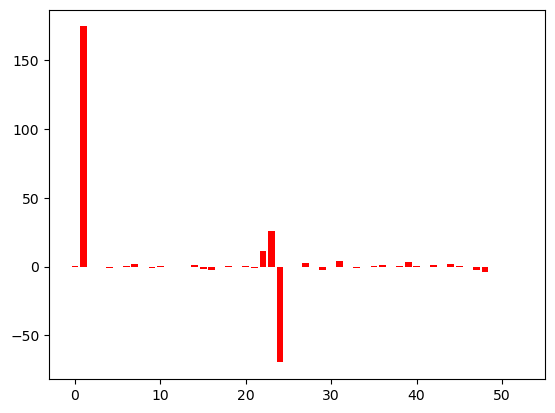

In [26]:
from matplotlib import pyplot

# get importance
importance = grid_search_ls.best_estimator_.coef_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance,color='red')
pyplot.show()

## Random forest **regressor**

Using grid search for rfregressor

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
# Assuming you have your training data in 'X_train' and target variable in 'y_train'

# Step 2: Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Step 3: Define the Hyperparameter Grid
param_grid = {
    'n_estimators': [100, 300, 500],  # Number of trees in the forest
    'max_depth': [None, 10, 20],      # Maximum depth of the tree
    'min_samples_split': [2, 5, 10]   # Minimum number of samples required to split an internal node
}


# Step 4: Grid Search with Cross-Validation
k_folds = 5  # Choose the number of folds (typically 5 or 10)

grid_search_RF = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=k_folds, scoring='neg_mean_squared_error',verbose = 2,n_jobs=-1)
# Now perform the hyperparameter tuning on a subset of your data (e.g., 20% of the data)
subset_size = 1000  # Use 20% of the data for hyperparameter tuning
subset_indices = np.random.choice(X_train_transform.shape[0], size=subset_size, replace=False)
X_subset = X_train_transform[subset_indices]  # Assuming X_train is a csr_matrix
y_subset = y_train.iloc[subset_indices]  # Assuming y_train is a Series


# Fit the GridSearchCV on the subset data
grid_search_RF.fit(X_subset, y_subset)

# Get the best hyperparameters and best estimator
best_params = grid_search_RF.best_params_
best_model = grid_search_RF.best_estimator_

# Now, you can train your final model on the full dataset using the best hyperparameters
final_model_rf = RandomForestRegressor(**best_params)
final_model_rf.fit(X_train_transform, y_train)



Fitting 5 folds for each of 27 candidates, totalling 135 fits


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


RandomForestRegressor(max_depth=10)

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt


# Make predictions on training data using the best estimator from the grid search
y_train_pred = final_model_rf.predict(X_train_transform)

print("Random forest regressor metrics")
# Calculate mean squared error on training data
train_mse = mean_squared_error(y_train, y_train_pred)
print(f'MSE: {train_mse}')

# Calculate root mean squared error on training data
train_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
print(f'RMSE: {train_rmse}')

# Calculate mean absolute error on training data
train_mae = mean_absolute_error(y_train, y_train_pred)
print(f'MAE: {train_mae}')

# Calculate R-squared on training data
train_r2 = r2_score(y_train, y_train_pred)
print(f'R-squared: {train_r2}')

# Calculate adjusted R-squared on training data
n = len(y_train) #  Number of samples
p = X_train_transform.shape[1] #Number of predicted variables
train_adj_r2 = 1 - (1 - train_r2) * (n - 1) / (n - p - 1)
print(f'adjusted R-squared: {train_adj_r2}')


Random forest regressor metrics
MSE: 1.106711785984807
RMSE: 1.0520037005566125
MAE: 0.6716141516017632
R-squared: 0.999966111136638
adjusted R-squared: 0.9999660650175018


Feature improtance

Feature: 0, Score: 0.00007
Feature: 1, Score: 0.91819
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00026
Feature: 23, Score: 0.00009
Feature: 24, Score: 0.02067
Feature: 25, Score: 0.02216
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00075
Feature: 30, Score: 0.00012
Feature: 31, Score: 0.00058
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

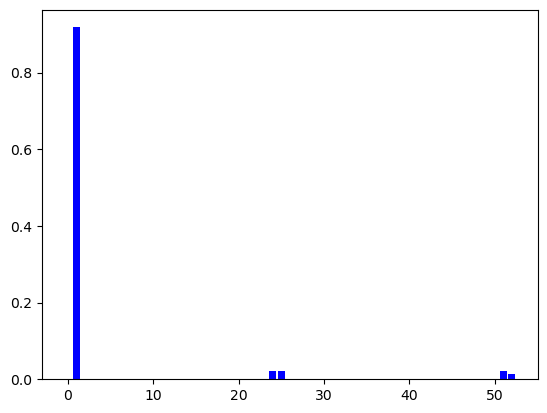

In [29]:
#random forest feature imporatance
from matplotlib import pyplot
importance = final_model_rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance,color = 'blue')
pyplot.show()

## XG boost **regressor**

Using GRID SEARCH for XG boost regressor

In [36]:
from sklearn.model_selection import GridSearchCV, KFold
from xgboost import XGBRegressor

# Set up k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

# Define the parameter grid for the XGBoost regressor
param_grid = {
    'n_estimators': [100,300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Initialize the XGBoost regressor
xgb = XGBRegressor()

# Set up the grid search with k-fold cross-validation
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=kfold, verbose = 2, n_jobs=-1)

# Fit the grid search to the training data
grid_search_xgb.fit(X_train_transform, y_train)

# Print the best parameters and best score from the grid search
print(f'Best parameters: {grid_search_xgb.best_params_}')
print(f'Best score: {grid_search_xgb.best_score_}')


Fitting 5 folds for each of 27 candidates, totalling 135 fits


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
Best score: 0.9999696727559206


In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt



# Make predictions on training data using the best estimator from the grid search
y_train_pred = grid_search_xgb.best_estimator_.predict(X_train_transform)

print("XGboost regressor Metrics")
# Calculate mean squared error on training data
train_mse = mean_squared_error(y_train, y_train_pred)
print(f'MSE: {train_mse}')

# Calculate root mean squared error on training data
train_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
print(f'RMSE: {train_rmse}')

# Calculate mean absolute error on training data
train_mae = mean_absolute_error(y_train, y_train_pred)
print(f'MAE: {train_mae}')

# Calculate R-squared on training data
train_r2 = r2_score(y_train, y_train_pred)
print(f'R-squared: {train_r2}')

# Calculate adjusted R-squared on training data
n = len(y_train) #  Number of samples
p = X_train_transform.shape[1] #Number of predicted variables
train_adj_r2 = 1 - (1 - train_r2) * (n - 1) / (n - p - 1)
print(f'adjusted R-squared: {train_adj_r2}')

XGboost regressor Metrics
MSE: 0.08417324665525888
RMSE: 0.29012625985122215
MAE: 0.11443987410221616
R-squared: 0.9999974225126264
adjusted R-squared: 0.9999974190049403


Feature imporatance using XGregressor

Feature: 0, Score: 0.00001
Feature: 1, Score: 0.54380
Feature: 2, Score: 0.00001
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00002
Feature: 6, Score: 0.00001
Feature: 7, Score: 0.00001
Feature: 8, Score: 0.00001
Feature: 9, Score: 0.00001
Feature: 10, Score: 0.00001
Feature: 11, Score: 0.00001
Feature: 12, Score: 0.00001
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00001
Feature: 15, Score: 0.00001
Feature: 16, Score: 0.00002
Feature: 17, Score: 0.00001
Feature: 18, Score: 0.00001
Feature: 19, Score: 0.00001
Feature: 20, Score: 0.00001
Feature: 21, Score: 0.00001
Feature: 22, Score: 0.00615
Feature: 23, Score: 0.00128
Feature: 24, Score: 0.41533
Feature: 25, Score: 0.02723
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00001
Feature: 28, Score: 0.00001
Feature: 29, Score: 0.00269
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00304
Feature: 32, Score: 0.00001
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00002
Feature: 35, Score: 0.00002
Fe

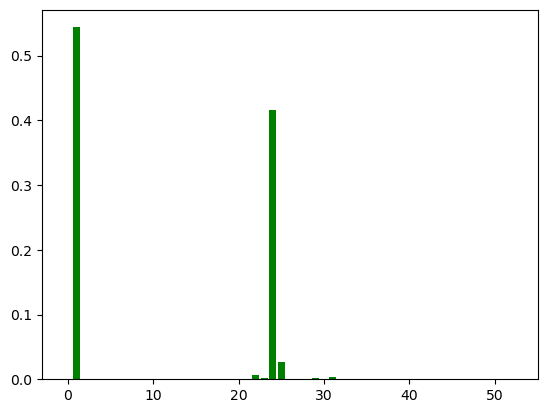

In [38]:
# xgboost for feature importance on a regression problem
from matplotlib import pyplot

importance = grid_search_xgb.best_estimator_.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance,color='green')
pyplot.show()

From above plots for feature imporatance it can be observed that XGboost regressor is improving feature improtance and the RMSE score is some what similar for both randomforest and XG boost regressor

# TEST data

In [39]:
test = pd.read_csv("https://raw.githubusercontent.com/priyankaa-k/Databases1/main/Regression_test.csv")
test.head()

,trip,date,dayPart,exWeatherTag,originLocation,destinationLocation,distance,type,weight,packageType,carrier
0,t333282728025,2017-09-27,night,NaN,S2,D8,2000,NaN,50,NaN,C
1,t35583500660,2017-12-12,day,snow,S2,D1,600,NaN,22,NaN,A
2,t117664376784,2018-11-18,day,NaN,S7,D1,1600,expedited,30,NaN,D
3,t261320757828,2019-11-18,day,NaN,S5,D6,2200,NaN,32,NaN,B
4,t147086054909,2019-06-02,night,heat,S6,D7,2600,NaN,7,NaN,B


In [40]:
test.shape

(802, 11)

In [41]:
#saving the trip feature in test_trip df
test_trip = pd.DataFrame()
test_trip['trip'] = test['trip']

In [42]:
feature_engg(test)
handling_missing_values(test)
# outliers(test)
test = dropSelectedColumns(test, drop_columns)

In [43]:
test_transformed = full_pipeline.transform(test)
print(f"X_test transformed.shape: {test_transformed.shape}")

X_test transformed.shape: (802, 53)


### Evaluating your best model on TESTING data

Choose among grid_search_rr, final_model_rf, and grid_search_xgb, the model with best performance

In [44]:
final_model = grid_search_xgb.best_estimator_
test_predictions = final_model.predict(test_transformed)

In [45]:
test_pred_df = pd.DataFrame(test_predictions, columns= ['cost'])
test_pred_df.head()

,cost
0,57.318188
1,29.574402
2,63.076778
3,72.683380
4,34.899906


In [46]:
df_output = pd.DataFrame()
df_output['trip'] = test_trip['trip']
df_output['cost'] = test_predictions

In [47]:
df_output.head()

,trip,cost
0,t333282728025,57.318188
1,t35583500660,29.574402
2,t117664376784,63.076778
3,t261320757828,72.683380
4,t147086054909,34.899906


In [48]:

df_output.to_csv('submission4_8_1.csv' , index=False)

[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   2.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   2.7s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   5.7s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   5.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   6.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=500; total time=   9.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=500; total time=   9.3s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   2.9s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   2.9s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   2.9s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=300; total time=   9.5s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=300; total time=   8.7s
[CV] END ..learning_rate=0.0

By submiting above file on kaggale, got RMSE score as 0.78


# **Conclusion**

In this project, we tackled the task of optimizing the delivery network for a logistics company. To achieve this, we performed data preprocessing to handle missing values, encode categorical variables, removing outliers and  scale the features. We then explored three different regression models: Lasso regression, Random Forest regression, and XGBoost regression.

After training and evaluating the models on the training dataset, we found that all three models produced promising results. However, the best performance was achieved by the XGBoost regression model, which yielded a Root Mean Squared Error (RMSE) score of 0.78 on kaggle test data. This implies that, on average, the model's predictions deviated from the actual delivery costs by approximately 0.78 units, which is reasonably accurate for this type of prediction.

By leveraging the predictive capabilities of this model, the logistics company can make informed decisions, streamline delivery processes, and achieve cost efficiencies, ultimately leading to improved customer satisfaction and business success.

# References

www.kaggle.com  

https://machinelearningmastery.com/calculate-feature-importance-with-python/

https://towardsdatascience.com/

https://scikit-learn.org/